In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import imageio.v2 as iio
from tifffile import imread
import copy
np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4
torch.set_printoptions(precision=3, sci_mode=False)

In [12]:
#I copied a bunch of this stuff from lab 5
def plot_matrix_grid(V, cmap='bwr'):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    The default cmap is "bwr" (blue-white-red) but can also be "gray".
    """
    if isinstance(V, torch.Tensor):
        V = V.detach().numpy()
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmax = np.percentile(np.abs(V), [99.9])      # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap(cmap))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axes.flat[len(V):]:
        ax.set_axis_off()
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

In [13]:
def load_mnist_for_convnet(filename):
    """
    Loads the MNIST data from a Numpy NPZ file and returns two PyTorch tensors:
    X: a float tensor with shape (N,1,28,28) where N is the number of images in the file
    y: an int64 tensor with shape (N,) containing the class targets for the images.
    The pixels values are scaled to be in range [0,1] where 0 is black and 1 is white.
    """
    # Your code here. Aim for 7-10 lines.
    with np.load(filename) as data:

        X = data['X'].astype(np.float32)
        y = data['y'].astype(np.int64)
    X /= 255
    X = X.reshape(-1, 1, 28, 28)  # (N,1,28,28)
    return torch.from_numpy(X), torch.from_numpy(y)

# It should be used like this:
# X_trn, y_trn = load_mnist_for_convnet("mnist_train.npz")
# X_tst, y_tst = load_mnist_for_convnet("mnist_test.npz")

In [14]:
# My code starts here

# Open a file in write mode to save image data to
dataFile = open("imageData.npz", "w")

testArray = np.array([[0, 1], [1, 0]])
# Double the length and width of the array 4 times.
for i in range(4):
    testArray = np.concatenate((testArray, np.copy(testArray)), axis=0)
    testArray = np.concatenate((testArray, np.copy(testArray)), axis=1)

print(testArray)
print(testArray.shape)

# NOTES WHEN SAVING:
# - the .npz has 2 "files": X and y.
# - Save it like this:
#   - Make the X array
#   - Make the y array (array of integers representing each class)
#   - np.savez(dataFile, X=X, y=y)

# Close the file now that we're done with it (for now)
dataFile.close()



[[0 1 0 ... 1 0 1]
 [1 0 1 ... 0 1 0]
 [0 1 0 ... 1 0 1]
 ...
 [1 0 1 ... 0 1 0]
 [0 1 0 ... 1 0 1]
 [1 0 1 ... 0 1 0]]
(32, 32)


In [15]:
def getImages(path, currentClass):
    # Images are different dimensions depending on which dataset they come from.
    # Dataset 1 images are 224 by 244 pixels with 3 RGB channels each.
    # Dataset 2 images are 300 by 300 pixels with 3 RGB channels each.
    # Dataset 3 images are 512 by 512 pixels with 3 RGB channels each.

    counter = 0
    newArray = True
    arrayIndex = 0
    arrays = []

    fileList = os.listdir(path + "\\" + currentClass)

    for filename in fileList:

        f = os.path.join(path, currentClass, filename)
        
        if os.path.isfile(f) and filename != ".DS_Store":
            if counter % 2 == 0:
                newArray = True

            if newArray:
                arrays.append(iio.imread(f).reshape((1, 224, 224, 3)).astype(np.uint8))
                arrayIndex = len(arrays) - 1
                newArray = False
            else:
                arrays[arrayIndex] = np.concatenate((arrays[arrayIndex], iio.imread(f).reshape((1, 224, 224, 3)).astype(np.uint8)), axis=0)

            counter = counter + 1

    print(counter)

    while len(arrays) > 1:
        lastArrays = arrays
        arrays = []
        arrayIndex = 0

        counter = 0
        for nparr in lastArrays:
            if counter % 2 == 0:
                newArray = True

            if newArray:
                arrays.append(nparr)
                arrayIndex = len(arrays) - 1
                newArray = False
            else:
                arrays[arrayIndex] = np.concatenate((arrays[arrayIndex], nparr), axis=0)

            counter = counter + 1

        # print(arrays[0].shape)

    # Finally, what all this was for - the image data with shape (2000, 224, 224, 3)
    # - 2000 images, 244 by 244 pixels, 3 color channels
    return arrays[0]

class1Test_X = getImages("images\\Dataset 1\\Dataset 1\\Colorectal Cancer", "STR")
class2Test_X = getImages("images\\Dataset 1\\Dataset 1\\Colorectal Cancer", "MUS")
class3Test_X = getImages("images\\Dataset 1\\Dataset 1\\Colorectal Cancer", "NORM")
'''
class1Test_X = getImages("images\\Dataset 2\\Dataset 2\\Prostate Cancer", "gland")
class2Test_X = getImages("images\\Dataset 2\\Dataset 2\\Prostate Cancer", "nongland")
class3Test_X = getImages("images\\Dataset 2\\Dataset 2\\Prostate Cancer", "tumor")
'''
'''
class1Test_X = getImages("images\\Dataset 3\\Dataset 3\\Animal Faces", "wild")
class2Test_X = getImages("images\\Dataset 3\\Dataset 3\\Animal Faces", "dog")
class3Test_X = getImages("images\\Dataset 3\\Dataset 3\\Animal Faces", "cat")
'''

FileNotFoundError: [Errno 2] No such file or directory: 'images\\Dataset 1\\Dataset 1\\Colorectal Cancer\\STR'

(2000, 224, 224, 3)
(2000, 224, 224, 3)
(2000, 224, 224, 3)
(2000, 3, 224, 224)
(2000, 3, 224, 224)
(2000, 3, 224, 224)


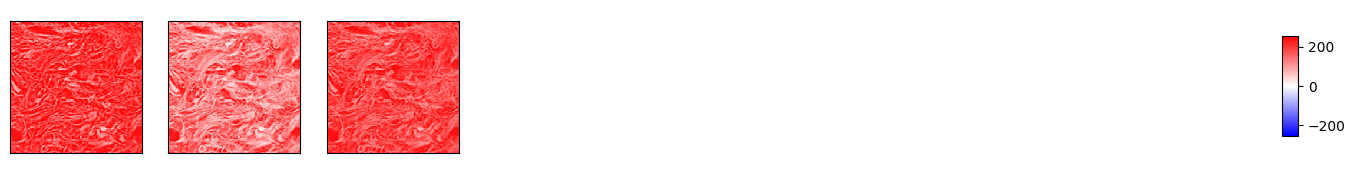

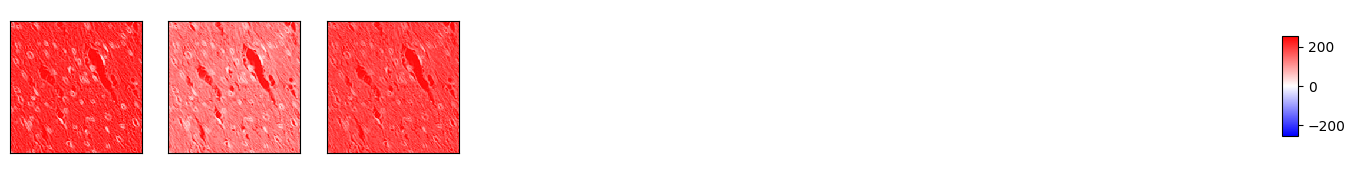

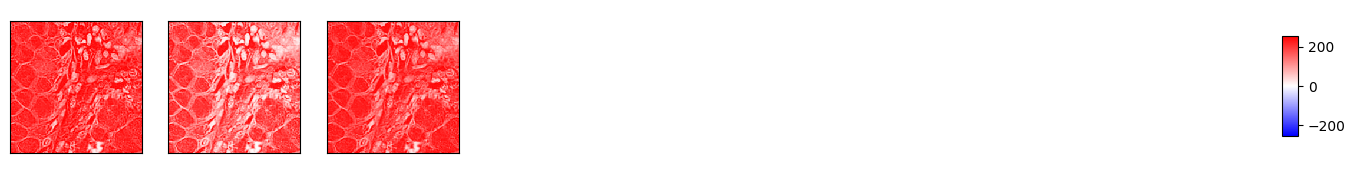

In [ ]:
print(class1Test_X.shape)
print(class2Test_X.shape)
print(class3Test_X.shape)

c1_X = np.swapaxes(class1Test_X, 1, 3)
c2_X = np.swapaxes(class2Test_X, 1, 3)
c3_X = np.swapaxes(class3Test_X, 1, 3)

print(c1_X.shape)
print(c2_X.shape)
print(c3_X.shape)

plot_matrix_grid(c1_X[0])
plot_matrix_grid(c2_X[0])
plot_matrix_grid(c3_X[0])

In [ ]:
# Set up the y data
# CLASS LEGEND:
# - Dataset 1: STR = 0, MUS = 1, NORM = 2
# - Dataset 2: gland = 0, nongland = 1, tumor = 2
# - Dataset 3: wild = 0, dog = 1, cat = 2
allClasses = [["STR", "MUS", "NORM"],
              ["gland", "nongland", "tumor"],
              ["wild", "dog", "cat"]]
classes = allClasses[0]
c1_y = np.zeros((2000,)).astype(np.uint8)
c2_y = np.zeros((2000,)).astype(np.uint8) + 1
c3_y = np.zeros((2000,)).astype(np.uint8) + 2

print(c1_y[0])
print(c2_y[0])
print(c3_y[0])

# Shuffle all the data
all_X = np.concatenate((c1_X, c2_X), axis = 0)
print(all_X.shape)
all_X = np.concatenate((all_X, c3_X), axis = 0)
print(all_X.shape)
all_y = np.concatenate((c1_y, c2_y), axis = 0)
print(all_y.shape)
all_y = np.concatenate((all_y, c3_y), axis = 0)
print(all_y.shape)

p = np.random.permutation(all_X.shape[0])
all_X = all_X[p]
all_y = all_y[p]
print(all_X.shape)
print(all_y.shape)

0
1
2
(4000, 3, 224, 224)
(6000, 3, 224, 224)
(4000,)
(6000,)
(6000, 3, 224, 224)
(6000,)


MUS
STR
NORM


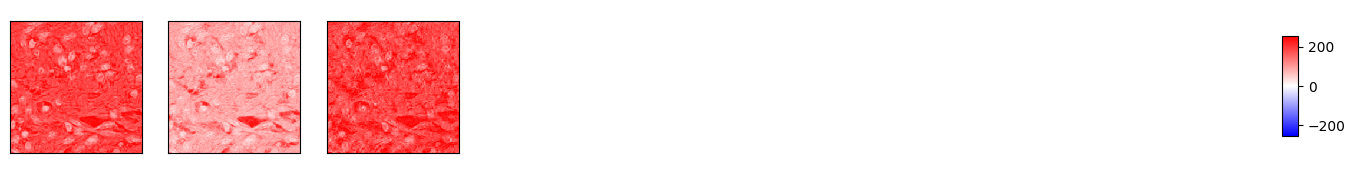

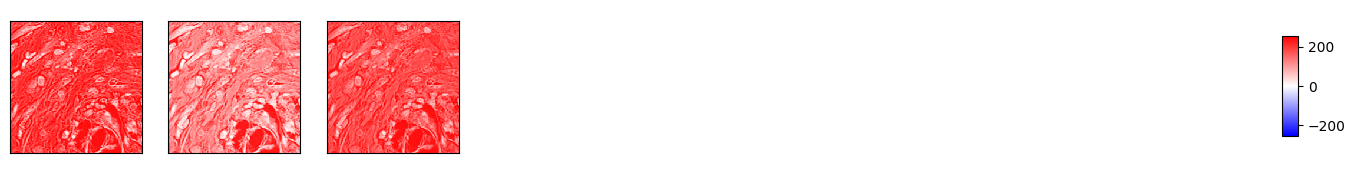

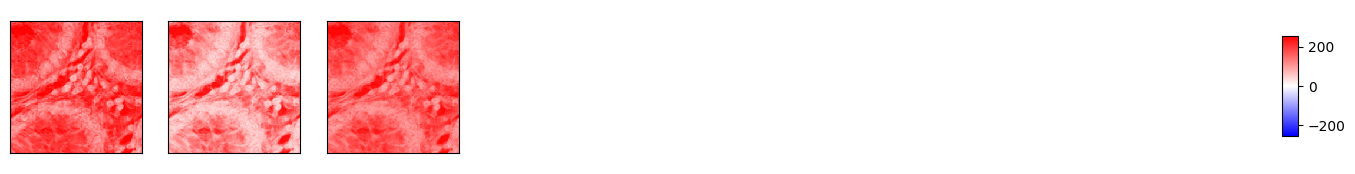

In [ ]:
def printClass(num):
    print(classes[num])

printClass(all_y[0])
plot_matrix_grid(all_X[0])
printClass(all_y[1])
plot_matrix_grid(all_X[1])
printClass(all_y[2])
plot_matrix_grid(all_X[2])

In [ ]:
# Train & Test groups

train_weight = 7
test_weight = 3
total_weight = train_weight + test_weight

total_rows = all_X.shape[0]
train_rows = round(total_rows * (train_weight / total_weight) - 0.5)
test_rows = round(total_rows * (test_weight / total_weight) - 0.5)

trn_X = all_X[0:train_rows]
tst_X = all_X[train_rows:]
trn_y = all_y[0:train_rows]
tst_y = all_y[train_rows:]

print(trn_X[0:5].astype(np.uint8))

[[[[167 168 176 ... 172 162 153]
   [186 188 187 ... 171 165 162]
   [211 216 209 ... 188 180 180]
   ...
   [167 152 141 ... 200 182 179]
   [194 180 172 ... 176 169 181]
   [208 204 205 ... 178 181 190]]

  [[ 81  78  83 ...  76  68  61]
   [ 75  74  76 ...  67  64  57]
   [101 103 100 ...  93  84  77]
   ...
   [ 83  71  61 ... 102  87  82]
   [117 105  96 ...  73  70  82]
   [137 128 129 ...  81  81  87]]

  [[166 178 170 ... 157 163 162]
   [179 168 186 ... 130 154 175]
   [194 182 200 ... 143 157 181]
   ...
   [178 171 183 ... 192 170 163]
   [204 191 192 ... 179 163 164]
   [239 239 234 ... 153 165 173]]]


 [[[158 186 203 ... 150 158 161]
   [167 186 205 ... 181 175 166]
   [180 199 207 ... 146 141 135]
   ...
   [249 245 234 ... 136 155 211]
   [239 255 239 ... 146 147 208]
   [179 243 224 ... 131 121 151]]

  [[100 132 141 ...  77  83  84]
   [113 130 143 ...  99  94  86]
   [128 141 143 ...  70  68  64]
   ...
   [185 172 158 ...  70  85 122]
   [174 192 154 ...  74  86 147

['trn_X', 'trn_y', 'tst_X', 'tst_y']


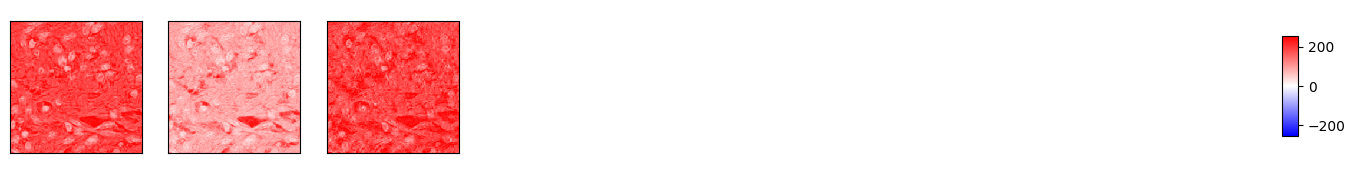

In [ ]:
np.savez("npzDatasets/Dataset1Data.npz", trn_X=trn_X, trn_y=trn_y, tst_X=tst_X, tst_y=tst_y)

data = np.load("npzDatasets/Dataset1Data.npz")
# print list of "files" (labelled arrays)
print(data.files)
plot_matrix_grid(data['trn_X'][0])
data.close()

TO-DO:
- set up the y arrays
    - DONE
- shuffle the data
    - DONE
- split into train & test groups
    - DONE
- save as .npz files
    - DONE
- Write progress report
- train a cnn machine
- more stuff later...

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:

'''
        Load pretrained ResNet18 and modify for our input
        - Uses pretrained weights from ImageNet, giving us strong initial feature extractors

        ResNet18 Base:

Uses pretrained weights from ImageNet, giving us strong initial feature extractors
Shallower than larger ResNets (like ResNet50), trading some accuracy for faster training and less memory usage
Already handles 3-channel RGB input matching our data format


Feature Extraction Design:


Splits the forward pass to capture intermediate features before classification
Stores features in self.features for t-SNE visualization
Allows us to see what the network learns before making final classifications
Useful for understanding if the model is learning meaningful representations


Final Layer Modification:


Changes output dimension to 3 (matching our classes)
Keeps all other layers intact to preserve pretrained knowledge
Only this layer starts from scratch, speeding up training

'''

class ImageClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
       
    

        self.resnet = resnet18(pretrained=True)
        
        # Modify final fully connected layer for our number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
        
        # Add a way to get features before classification
        self.features = None
        
    def forward(self, x):
        # Get features from all layers except final fc
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        self.features = torch.flatten(x, 1)
        
        # Final classification
        x = self.resnet.fc(self.features)
        return x


In [3]:

def train_model(model, train_loader, test_loader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_acc = 0.0
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Evaluation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
        
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    
    return train_losses, test_accuracies


In [10]:

def extract_features_and_visualize(model, data_loader, device, classes):
    model.eval()
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Extracting features'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features_list.append(model.features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    features = np.concatenate(features_list)
    labels = np.concatenate(labels_list)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of CNN features')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.show()


In [6]:
#to run on gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = np.load("Dataset1Data.npz")

# Convert to torch tensors and create datasets
trn_X = torch.FloatTensor(data['trn_X']).to(device)
trn_y = torch.LongTensor(data['trn_y']).to(device)
tst_X = torch.FloatTensor(data['tst_X']).to(device)
tst_y = torch.LongTensor(data['tst_y']).to(device)

train_dataset = TensorDataset(trn_X, trn_y)
test_dataset = TensorDataset(tst_X, tst_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Initialize and train model
model = ImageClassifier(num_classes=3).to(device)
model = model.to(device)

train_losses, test_accuracies = train_model(model, train_loader, test_loader, device)


Using device: cuda


/home/hussein/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hussein/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 132/132 [00:10<00:00, 12.26it/s]


Epoch 1, Loss: 0.3041, Test Accuracy: 60.67%


Epoch 2/10: 100%|██████████| 132/132 [00:10<00:00, 13.12it/s]


Epoch 2, Loss: 0.1485, Test Accuracy: 91.33%


Epoch 3/10: 100%|██████████| 132/132 [00:10<00:00, 13.11it/s]


Epoch 3, Loss: 0.1406, Test Accuracy: 88.11%


Epoch 4/10: 100%|██████████| 132/132 [00:10<00:00, 13.04it/s]


Epoch 4, Loss: 0.1052, Test Accuracy: 97.61%


Epoch 5/10: 100%|██████████| 132/132 [00:10<00:00, 13.03it/s]


Epoch 5, Loss: 0.0745, Test Accuracy: 95.06%


Epoch 6/10: 100%|██████████| 132/132 [00:10<00:00, 13.00it/s]


Epoch 6, Loss: 0.0382, Test Accuracy: 68.89%


Epoch 7/10: 100%|██████████| 132/132 [00:10<00:00, 13.00it/s]


Epoch 7, Loss: 0.0647, Test Accuracy: 98.17%


Epoch 8/10: 100%|██████████| 132/132 [00:10<00:00, 13.02it/s]


Epoch 8, Loss: 0.0767, Test Accuracy: 93.89%


Epoch 9/10: 100%|██████████| 132/132 [00:10<00:00, 13.02it/s]


Epoch 9, Loss: 0.0552, Test Accuracy: 91.22%


Epoch 10/10: 100%|██████████| 132/132 [00:10<00:00, 13.01it/s]


Epoch 10, Loss: 0.0626, Test Accuracy: 90.17%


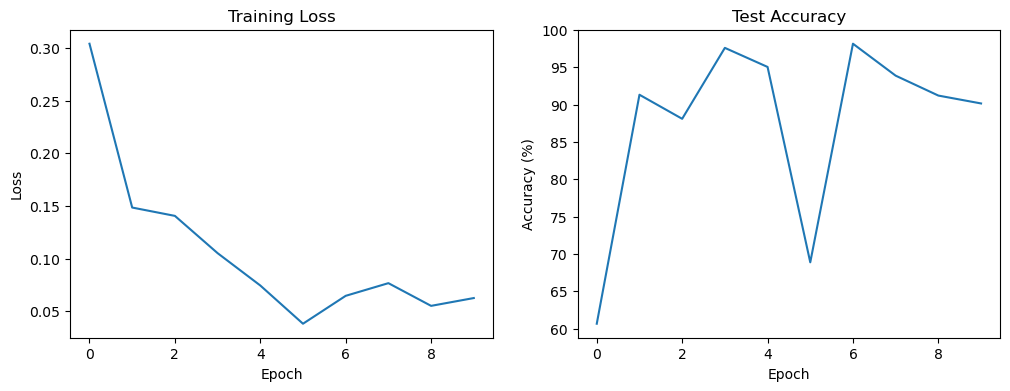

Extracting features: 100%|██████████| 57/57 [00:01<00:00, 44.36it/s]


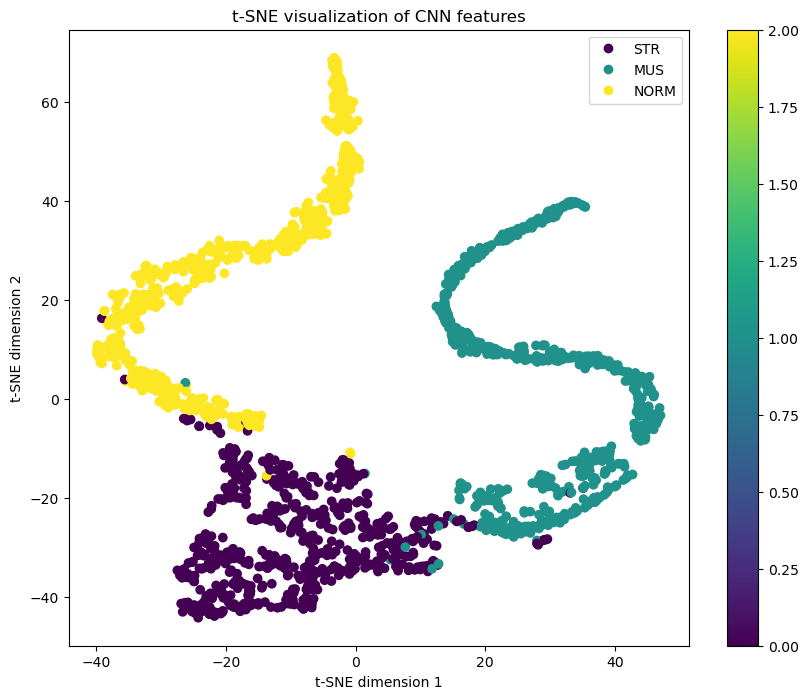

In [ ]:
# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Visualize features using t-SNE
classes = ["STR", "MUS", "NORM"] 
extract_features_and_visualize(model, test_loader, device, classes)



Training Performance:

Loss decreases steadily from 0.3041 to 0.0626, indicating good convergence
Test accuracy improves rapidly in early epochs (60.67% to 91.33%)
Peak performance at epoch 7 with 98.17% accuracy
Slight performance degradation in final epochs (ending at 90.17%) suggests minor overfitting

t-SNE Visualization:

Clear separation between the three classes (STR, MUS, NORM) in feature space
NORM class (yellow) forms a distinct curved cluster
MUS class (teal) shows an S-shaped pattern, well-separated from others
STR class (purple) clusters densely in the lower region
Minimal overlap between classes indicates strong discriminative features learned by the ResNet model

The results suggest the model successfully learned to distinguish between the three tissue types, though some fine-tuning of the training process (like early stopping at epoch 7) could potentially improve final performance by preventing overfitting.